# Phase 1 - (Convolutional) Neural Networks

Please follow the notebook in order. Make sure to add code where indicated by `''' TODO '''` or `# YOUR CODE HERE`. Ensure your notebook is easy to follow. All written report answers should be provided in the notebook itself.

You may find [this](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) pytorch tutorial helpful.

In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## 1. Loading & Visualizing Data

Please use MNIST for this Phase. MNIST is a digit classification dataset, with greyscale 28x28 images, and 10 classes (numbers 0-9). See [documentaion.](https://pytorch.org/vision/0.15/generated/torchvision.datasets.MNIST.html) You can also see the MNIST_Tutorial.ipynb

Please complete loading the data.

Please also complete `show_imgs()`. Function should input the dataloader, and show random 10 images and their labels as title to plot. Make sure the 10 images are organized in a grid or format or with matplotlib axis.

In [3]:
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

tensor([2, 2, 3, 8, 2, 0, 6, 6, 2, 1, 9, 3, 7, 5, 4, 0, 4, 8, 7, 8, 3, 1, 4, 9,
        4, 2, 9, 2, 0, 7, 1, 2])
tensor([7, 3, 9, 3, 9, 8, 4, 2, 9, 3, 5, 4, 2, 6, 3, 8, 6, 2, 8, 8, 5, 7, 7, 7,
        8, 1, 9, 8, 4, 0, 1, 2])
tensor([7, 9, 5, 7, 6, 3, 8, 9, 8, 3, 0, 0, 2, 7, 3, 7, 7, 5, 4, 3, 7, 0, 8, 1,
        2, 1, 5, 0, 3, 6, 5, 2])
tensor([4, 1, 2, 1, 8, 1, 7, 2, 0, 8, 1, 2, 8, 1, 7, 6, 6, 2, 2, 3, 6, 0, 0, 8,
        2, 7, 8, 9, 3, 4, 1, 4])
tensor([6, 5, 0, 6, 4, 4, 0, 1, 2, 5, 8, 3, 7, 4, 4, 0, 8, 2, 9, 4, 0, 9, 5, 1,
        4, 3, 9, 7, 2, 6, 4, 3])
tensor([4, 3, 8, 2, 2, 9, 7, 5, 0, 0, 6, 0, 6, 5, 4, 1, 1, 8, 6, 4, 9, 4, 9, 4,
        1, 4, 3, 0, 7, 9, 4, 3])
tensor([2, 8, 5, 0, 9, 5, 8, 7, 1, 0, 1, 8, 0, 5, 6, 4, 0, 8, 7, 9, 4, 7, 9, 6,
        6, 1, 1, 5, 2, 7, 8, 6])
tensor([1, 6, 0, 7, 0, 4, 1, 1, 0, 1, 4, 4, 5, 8, 1, 6, 0, 2, 4, 6, 4, 3, 0, 6,
        2, 8, 4, 0, 6, 3, 4, 6])
tensor([8, 6, 9, 6, 1, 9, 8, 5, 2, 4, 8, 4, 7, 3, 6, 4, 8, 9, 0, 6, 6, 5, 8, 1,
        6, 8, 8,

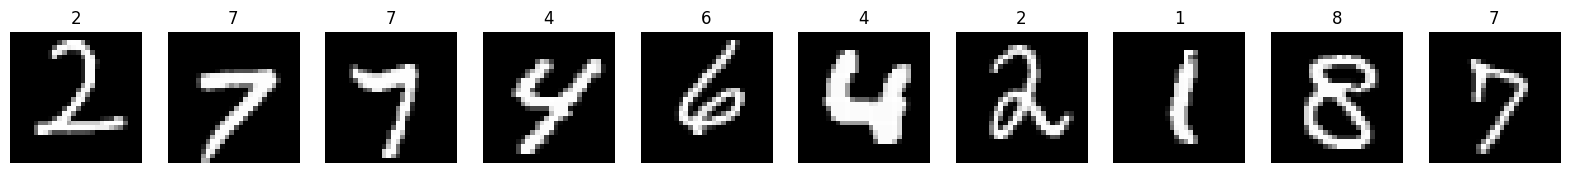

In [4]:
import torchvision
# Function should input the dataloader, and show random 10 images and their labels as title to plot

def show_imgs(imgs):
    # Create 10 subplots all in a row
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        # get some random training images

        dataiter = iter(train_loader)
        images, labels = next(dataiter)
        print(labels)
        npimg = torchvision.utils.make_grid(images[0]).numpy()
        ax[i].axis('off')
        ax[i].imshow(np.transpose(npimg, (1, 2, 0)))
        ax[i].set_title(labels[0].item())

show_imgs(train_loader)

## 2. Utility Functions

Please complete `train()` and `plot_learning_curves()` functions. `test_accuracy()` has already been provided to you.

In [5]:
def test_accuracy(model, test_loader, input_size, loss_fn, device):
    model.to(device)
    correct = 0
    total = 0
    loss_valid, loss_train = [], []
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            valid_loss = loss_fn(outputs, labels)
            loss_valid.append(valid_loss.item())
    avg_valid_loss = sum(loss_valid) / len(loss_valid)
    #print('Accuracy: %d %%' % (100 * correct / total))
    return avg_valid_loss, (100 * correct / total)


### 2.1 Train Function
Please refer to the train function in `MNIST_Classifier.ipynb` to complete this function. You will need to store the loss and accuracies per iteration to plot. Please print the loss, accuracy and time taken for training each epoch.

In [6]:
import time

def train(model, loss_fn, optimizer, train_loader, batch_size, num_epochs, device):
    acc_arr_train, acc_arr_valid, loss_avg_valid, loss_avg_train, loss_arr_train = [], [], [], [], []

    # Iterate through all Epochs
    for epoch in range(num_epochs):
      start_epoc_time = time.perf_counter()
      for i, data in enumerate(train_loader):
        # scale images and load images/labels
        images, labels = data[0].cuda(), data[1].cuda()
        
        optimizer.zero_grad()                     # Zero collected gradients at each step
        outputs = model(images)                   # Forward Propagate
        loss = loss_function(outputs, labels)     # Calculate train Loss
        loss.backward()                           # Back propagate
        optimizer.step()                          # Update weights
        loss_arr_train.append(loss.item())        # Store Loss of current iteration
        
        # Print statistics on every 100th iteration
        if (i+1) % 100 == 0:
          # Average the past 100 iterations and append that Loss value
          window_train = loss_arr_train[(len(loss_arr_train)-100):]
          avg_train =  sum(window_train) / 100
          avg_valid, _ = test_accuracy(model, test_loader, 0, loss_function, device)
          loss_avg_valid.append(avg_valid)
          loss_avg_train.append(avg_train)
          

          print("""Epoch [%d/%d], Step [%d/%d], Train Loss: %.4f, Val Loss: %.4f"""
                %(epoch+1, num_epochs, i+1,
                len(train_data) // batch_size, loss.item(), avg_valid)) 

      time_epoc_stop = time.perf_counter() # Stop the timer

      # Average of train and validation accuracies:
      _, train_acc = test_accuracy(model, train_loader, 0, loss_function, None)
      _, test_acc = test_accuracy(model, test_loader, 0, loss_function, None)

      acc_arr_train.append(train_acc)
      acc_arr_valid.append(test_acc)

      # Print epoc, time taken for epoc, train accuracy, valid accuracy
      print("""Epoch [%d/%d], Time Taken: %.4f, Train Acc: %.4f, Valid Acc: %.4f"""
            % (epoch + 1, num_epochs, time_epoc_stop - start_epoc_time,
             train_acc, test_acc))
      print("--------------------------------------------------------------")

    return acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid

### 2.2 Plot Learning Curves Function
Plot the loss and accuracies from training

In [7]:
def plot_learning_curve(train_loss, valid_loss, title):
    plt.figure(0)
    plt.plot(range(0, len(train_loss*100), 100), train_loss, label = "Train Loss")
    plt.plot(range(0, len(valid_loss*100), 100), valid_loss, label = "Validation Loss")
    plt.legend()
    plt.title(title)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

## 3) Define CNNs

A 1-Layer Architecture is already defined for you (`Net`) as a reference. Please complete the definitions of the 2-Layer CNN (`Net2`), 5-Layer CNN (`Net5`). The network architecture definitions are provided to you. You must calculate some dimensions yourself.

**NOTE:** For now, please use ReLU activation. You will experiment with other activations in Section 5.

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = torch.flatten(x, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

### 3.1) 2-Layer CNN
Complete `Net2` class.

 Network Architecture:
* ***Layer 1 (Input)***: Convolutional; input channel = 1, output channel = 20, kernel size = 3, step size = 1.
* ***Layer 2 (Output)***: Fully connected; input dimension = < you find out >, output dimension = < you find out >.

In [9]:
# Define 2-Layer Network
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

## 4) Train and Evaluate

### 4.1) Here, you must test your utility functions (`train()` and `plot_learning_curves()`)with the 1-Layer Model. Please at this stage ensure your utility functions are working correctly.

**NOTE**: You can repeatedly use this below code black in Section 5 to run experiments, while making changes to the hyperparameters as requested.

In [10]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
acc_arr_train, acc_arr_valid, loss_avg_train, loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.3269, Val Loss: 0.3613
Epoch [1/5], Step [200/1875], Train Loss: 0.2998, Val Loss: 0.2644
Epoch [1/5], Step [300/1875], Train Loss: 0.1899, Val Loss: 0.3928
Epoch [1/5], Step [400/1875], Train Loss: 0.1996, Val Loss: 0.2225
Epoch [1/5], Step [500/1875], Train Loss: 0.2087, Val Loss: 0.2111
Epoch [1/5], Step [600/1875], Train Loss: 0.6296, Val Loss: 0.2540
Epoch [1/5], Step [700/1875], Train Loss: 0.2098, Val Loss: 0.2081
Epoch [1/5], Step [800/1875], Train Loss: 0.0249, Val Loss: 0.1991
Epoch [1/5], Step [900/1875], Train Loss: 0.0159, Val Loss: 0.1990
Epoch [1/5], Step [1000/1875], Train Loss: 0.2585, Val Loss: 0.1629
Epoch [1/5], Step [1100/1875], Train Loss: 0.1506, Val Loss: 0.1773
Epoch [1/5], Step [1200/1875], Train Loss: 0.4179, Val Loss: 0.2116
Epoch [1/5], Step [1300/1875], Train Loss: 0.2058, Val Loss: 0.1777
Epoch [1/5], Step [1400/1875], Train Loss: 0.4221, Val Loss: 0.1725
Epoch [1/5], Step [1500/1875], Train Loss: 0.1898, Val Lo

(0.20174027679796783, 96.24)

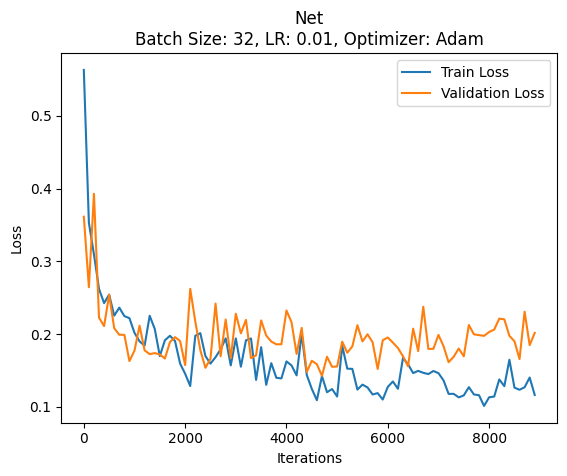

In [11]:
# Plot Learning Curves
plot_learning_curve(loss_avg_train, loss_avg_valid, "Net\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, loss_fn=loss_function, device=device)

### 4.2) Please also train your 2-Layer network to ensure it is working properly.

In [12]:
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

#print(net)
# Train Model
Net2_acc_arr_train, Net2_acc_arr_valid, Net2_loss_avg_train, Net2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.1107, Val Loss: 0.2352
Epoch [1/5], Step [200/1875], Train Loss: 0.2439, Val Loss: 0.1821
Epoch [1/5], Step [300/1875], Train Loss: 0.2288, Val Loss: 0.1575
Epoch [1/5], Step [400/1875], Train Loss: 0.1559, Val Loss: 0.1530
Epoch [1/5], Step [500/1875], Train Loss: 0.0487, Val Loss: 0.1401
Epoch [1/5], Step [600/1875], Train Loss: 0.4368, Val Loss: 0.1226
Epoch [1/5], Step [700/1875], Train Loss: 0.0871, Val Loss: 0.1442
Epoch [1/5], Step [800/1875], Train Loss: 0.1777, Val Loss: 0.1131
Epoch [1/5], Step [900/1875], Train Loss: 0.2904, Val Loss: 0.1309
Epoch [1/5], Step [1000/1875], Train Loss: 0.0270, Val Loss: 0.1038
Epoch [1/5], Step [1100/1875], Train Loss: 0.2637, Val Loss: 0.0993
Epoch [1/5], Step [1200/1875], Train Loss: 0.0678, Val Loss: 0.1176
Epoch [1/5], Step [1300/1875], Train Loss: 0.6337, Val Loss: 0.1282
Epoch [1/5], Step [1400/1875], Train Loss: 0.0495, Val Loss: 0.0911
Epoch [1/5], Step [1500/1875], Train Loss: 0.0652, Val Lo

(0.11549124330977444, 97.45)

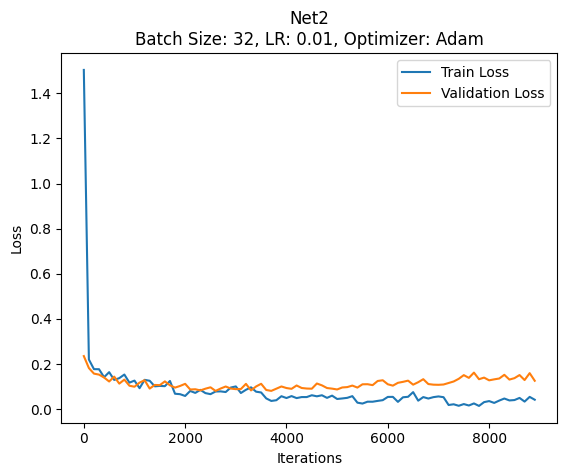

In [13]:
# Plot Learning Curves
plot_learning_curve(Net2_loss_avg_train, Net2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: Adam")

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, loss_fn=loss_function, device=device)

## 5) Experiments and Reporting

In this section you will use your utility functioins and model definitons from before, and test for different scenarios. There are report questions you must answer for all sections below. Please use the loss, accuracy, and learning curves to help answer questions.

**NOTE:** In this section we will only change different parameters, so you can call most of your functions from previous sections. Any modifications needed in code asked by the questions in Section 5, please add them in the code sections indicated by `# YOUR CODE HERE`

### 5.1) Learning Curves

#### **Q 5.1) What is a Learning curve and why is it useful? You can refer to learning curves you have plotted in Section 4.**

---

A Learning curve measures the validation and training loss for each iteration. It is useful because it tells us whether the model is overfitting or underfitting.

### 5.2) Learning Rates

Please plot the curves for three separate training instances with learning rates of 2e-3, 3e-4, 5e-2. Use the 2-Layer CNN.

#### **Q 5.2) For each learning rate, explain if the model is underfitting, overfitting, or is training well. Explain the difference between high learning rates and low learning rates in terms of the optimization process.**

In [14]:
# Learning Rate 2e-3, "LR1"
# Define Parameters
input_size = 784
num_classes = 10
lr = 0.002
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR1_acc_arr_train, LR1_acc_arr_valid, LR1_loss_avg_train, LR1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.2304, Val Loss: 0.3691
Epoch [1/5], Step [200/1875], Train Loss: 0.2339, Val Loss: 0.2309
Epoch [1/5], Step [300/1875], Train Loss: 0.3161, Val Loss: 0.1673
Epoch [1/5], Step [400/1875], Train Loss: 0.2839, Val Loss: 0.1530
Epoch [1/5], Step [500/1875], Train Loss: 0.0435, Val Loss: 0.1350
Epoch [1/5], Step [600/1875], Train Loss: 0.1527, Val Loss: 0.1287
Epoch [1/5], Step [700/1875], Train Loss: 0.2778, Val Loss: 0.1169
Epoch [1/5], Step [800/1875], Train Loss: 0.1550, Val Loss: 0.0984
Epoch [1/5], Step [900/1875], Train Loss: 0.1362, Val Loss: 0.0910
Epoch [1/5], Step [1000/1875], Train Loss: 0.1607, Val Loss: 0.0966
Epoch [1/5], Step [1100/1875], Train Loss: 0.0422, Val Loss: 0.0882
Epoch [1/5], Step [1200/1875], Train Loss: 0.0911, Val Loss: 0.0821
Epoch [1/5], Step [1300/1875], Train Loss: 0.1150, Val Loss: 0.1047
Epoch [1/5], Step [1400/1875], Train Loss: 0.1687, Val Loss: 0.0967
Epoch [1/5], Step [1500/1875], Train Loss: 0.0959, Val Lo

In [15]:
# Learning Rate 3e-4, "LR2"
# Define Parameters
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR2_acc_arr_train, LR2_acc_arr_valid, LR2_loss_avg_train, LR2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4944, Val Loss: 0.5932
Epoch [1/5], Step [200/1875], Train Loss: 0.2422, Val Loss: 0.3896
Epoch [1/5], Step [300/1875], Train Loss: 0.2805, Val Loss: 0.3285
Epoch [1/5], Step [400/1875], Train Loss: 0.1674, Val Loss: 0.2911
Epoch [1/5], Step [500/1875], Train Loss: 0.3374, Val Loss: 0.2747
Epoch [1/5], Step [600/1875], Train Loss: 0.3264, Val Loss: 0.2823
Epoch [1/5], Step [700/1875], Train Loss: 0.2629, Val Loss: 0.2607
Epoch [1/5], Step [800/1875], Train Loss: 0.2926, Val Loss: 0.2383
Epoch [1/5], Step [900/1875], Train Loss: 0.1657, Val Loss: 0.2293
Epoch [1/5], Step [1000/1875], Train Loss: 0.1096, Val Loss: 0.2209
Epoch [1/5], Step [1100/1875], Train Loss: 0.1505, Val Loss: 0.2066
Epoch [1/5], Step [1200/1875], Train Loss: 0.3251, Val Loss: 0.1984
Epoch [1/5], Step [1300/1875], Train Loss: 0.1119, Val Loss: 0.1960
Epoch [1/5], Step [1400/1875], Train Loss: 0.2079, Val Loss: 0.1855
Epoch [1/5], Step [1500/1875], Train Loss: 0.1027, Val Lo

In [16]:
# Learning Rate 5e-2, "LR3"
# Define Parameters
input_size = 784
num_classes = 10
lr = 5e-2
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
LR3_acc_arr_train, LR3_acc_arr_valid, LR3_loss_avg_train, LR3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.1247, Val Loss: 0.3722
Epoch [1/5], Step [200/1875], Train Loss: 0.3311, Val Loss: 0.2774
Epoch [1/5], Step [300/1875], Train Loss: 0.4073, Val Loss: 0.2655
Epoch [1/5], Step [400/1875], Train Loss: 0.1309, Val Loss: 0.2325
Epoch [1/5], Step [500/1875], Train Loss: 0.1541, Val Loss: 0.2428
Epoch [1/5], Step [600/1875], Train Loss: 0.3743, Val Loss: 0.2235
Epoch [1/5], Step [700/1875], Train Loss: 0.3203, Val Loss: 0.2064
Epoch [1/5], Step [800/1875], Train Loss: 0.1218, Val Loss: 0.1922
Epoch [1/5], Step [900/1875], Train Loss: 0.2503, Val Loss: 0.2379
Epoch [1/5], Step [1000/1875], Train Loss: 0.4794, Val Loss: 0.3366
Epoch [1/5], Step [1100/1875], Train Loss: 0.0469, Val Loss: 0.2733
Epoch [1/5], Step [1200/1875], Train Loss: 0.1332, Val Loss: 0.2523
Epoch [1/5], Step [1300/1875], Train Loss: 0.2534, Val Loss: 0.2178
Epoch [1/5], Step [1400/1875], Train Loss: 0.0420, Val Loss: 0.2153
Epoch [1/5], Step [1500/1875], Train Loss: 0.1470, Val Lo

LR=2e-3

Model is fit well with slight overfit because the validation and training accuracy are close together and it has also reached its optimum because the loss has stopped decreasing

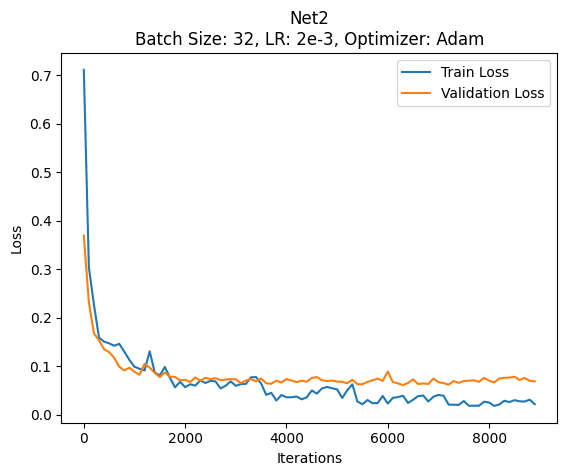

In [17]:
plot_learning_curve(LR1_loss_avg_train, LR1_loss_avg_valid, "Net2\nBatch Size: 32, LR: 2e-3, Optimizer: Adam")

LR=3e-4

Model is fit well because the validation and training accuracy are close together and it has also reached its optimum because the loss has stopped decreasing

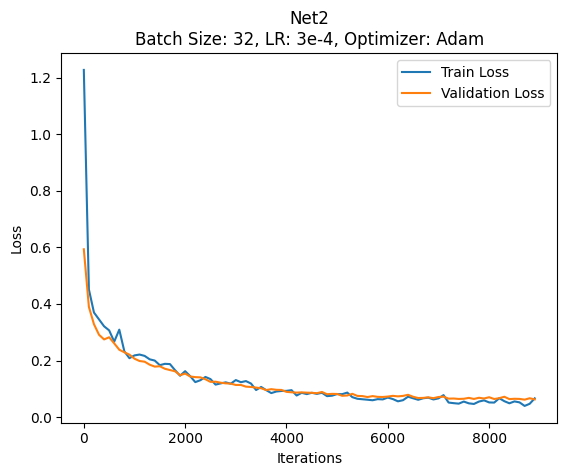

In [18]:
plot_learning_curve(LR2_loss_avg_train, LR2_loss_avg_valid, "Net2\nBatch Size: 32, LR: 3e-4, Optimizer: Adam")

LR=5e-2

Model is fit well with slight overfitting because the validation and training accuracy are close together and it has also reached its optimum because the loss has stopped decreasing

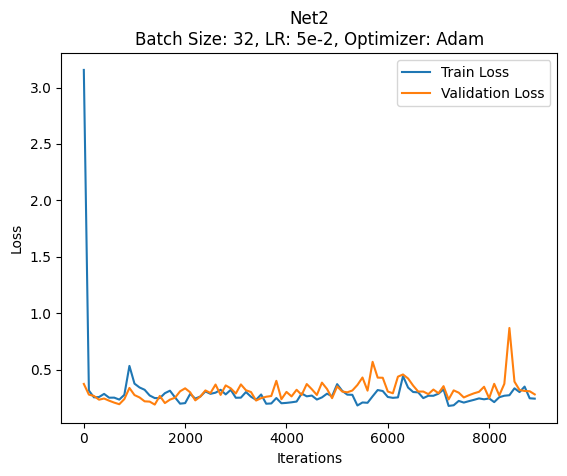

In [19]:
plot_learning_curve(LR3_loss_avg_train, LR3_loss_avg_valid, "Net2\nBatch Size: 32, LR: 5e-2, Optimizer: Adam")

---

### 5.3) Optimizer
The optimizer we have used before is Adam. Change the optimizer to use stochastic gradient descent (SGD), and SGD with momentum. Use 2-Layer CNN.

#### **Q 5.3) Explain the differences in Adam and both SGD optimizations. Compare the results of each optimizer based on the learning curves.**

Adam uses a changing learning rate throughout optimization while the SGD implementations both use a fixed learning rate. SGD with momentum takes into account previous gradient information for each step in an attempt to not get stuck in local minimum. Adam usually converges faster due to its changing learning rate.

In [20]:
# Optimizer SGD
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Train Model
SGD_acc_arr_train, SGD_acc_arr_valid, SGD_loss_avg_train, SGD_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.6582, Val Loss: 0.7130
Epoch [1/5], Step [200/1875], Train Loss: 0.5156, Val Loss: 0.4614
Epoch [1/5], Step [300/1875], Train Loss: 0.5134, Val Loss: 0.4034
Epoch [1/5], Step [400/1875], Train Loss: 0.4336, Val Loss: 0.3680
Epoch [1/5], Step [500/1875], Train Loss: 0.3835, Val Loss: 0.3477
Epoch [1/5], Step [600/1875], Train Loss: 0.6464, Val Loss: 0.3320
Epoch [1/5], Step [700/1875], Train Loss: 0.5211, Val Loss: 0.3547
Epoch [1/5], Step [800/1875], Train Loss: 0.2219, Val Loss: 0.3504
Epoch [1/5], Step [900/1875], Train Loss: 0.4675, Val Loss: 0.3384
Epoch [1/5], Step [1000/1875], Train Loss: 0.2629, Val Loss: 0.3146
Epoch [1/5], Step [1100/1875], Train Loss: 0.4445, Val Loss: 0.3178
Epoch [1/5], Step [1200/1875], Train Loss: 0.4417, Val Loss: 0.3021
Epoch [1/5], Step [1300/1875], Train Loss: 0.6447, Val Loss: 0.3279
Epoch [1/5], Step [1400/1875], Train Loss: 0.3646, Val Loss: 0.3054
Epoch [1/5], Step [1500/1875], Train Loss: 0.2650, Val Lo

In [21]:
# Optimizer SGD (Momentum = 0.9), SGDM
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
SGDM_acc_arr_train, SGDM_acc_arr_valid, SGDM_loss_avg_train, SGDM_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.4180, Val Loss: 0.4249
Epoch [1/5], Step [200/1875], Train Loss: 0.5185, Val Loss: 0.3600
Epoch [1/5], Step [300/1875], Train Loss: 0.4950, Val Loss: 0.3561
Epoch [1/5], Step [400/1875], Train Loss: 0.2064, Val Loss: 0.2799
Epoch [1/5], Step [500/1875], Train Loss: 0.2223, Val Loss: 0.2587
Epoch [1/5], Step [600/1875], Train Loss: 0.1007, Val Loss: 0.2388
Epoch [1/5], Step [700/1875], Train Loss: 0.1806, Val Loss: 0.2093
Epoch [1/5], Step [800/1875], Train Loss: 0.2024, Val Loss: 0.1962
Epoch [1/5], Step [900/1875], Train Loss: 0.0627, Val Loss: 0.1904
Epoch [1/5], Step [1000/1875], Train Loss: 0.2737, Val Loss: 0.1627
Epoch [1/5], Step [1100/1875], Train Loss: 0.0424, Val Loss: 0.1508
Epoch [1/5], Step [1200/1875], Train Loss: 0.4499, Val Loss: 0.1339
Epoch [1/5], Step [1300/1875], Train Loss: 0.0314, Val Loss: 0.1294
Epoch [1/5], Step [1400/1875], Train Loss: 0.0947, Val Loss: 0.1286
Epoch [1/5], Step [1500/1875], Train Loss: 0.1848, Val Lo

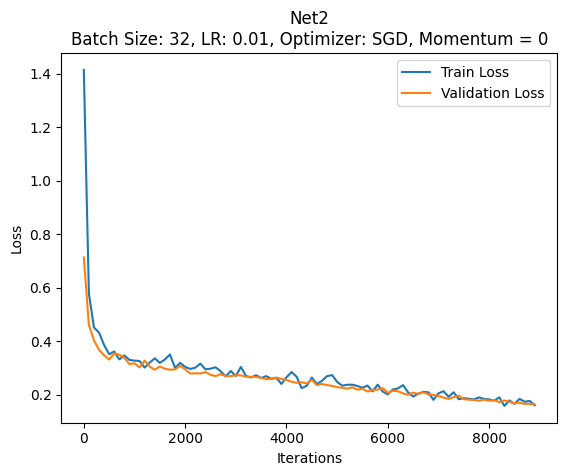

In [22]:
plot_learning_curve(SGD_loss_avg_train, SGD_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: SGD, Momentum = 0")

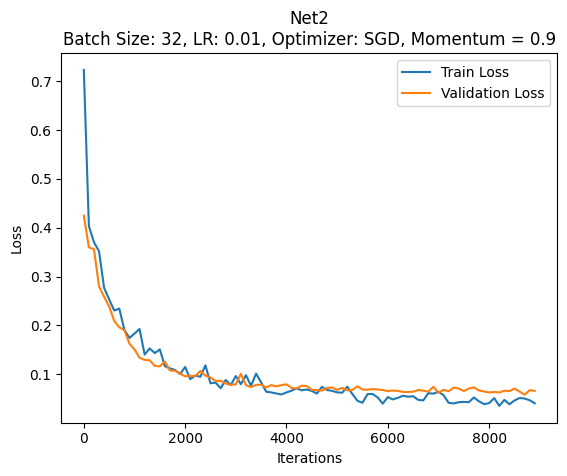

In [23]:
plot_learning_curve(SGDM_loss_avg_train, SGDM_loss_avg_valid, "Net2\nBatch Size: 32, LR: 0.01, Optimizer: SGD, Momentum = 0.9")

---

### 5.4) Initializing Weights

Initialize the weights to all zeros, all ones and all randomly initialized with a normal distribution. Use 2-Layer CNN.

#### **Q 5.4) How is the training process affected when we initialize our network weights differently? Based on what you observe, give a recommendation as to how weights should be initialized. Explain your reasoning.**

Doing random initialization is best because set values have the problem of having similar gradients initially which can lead to the model getting stuck in a local minimum.

In [24]:
# Define 2-Layer Network
class Net2_0(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_0, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(0)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [25]:
# Define 2-Layer Network
class Net2_1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.conv1.weight.data.fill_(1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        self.fc2.weight.data.fill_(1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [26]:
# Define 2-Layer Network
class Net2_rand(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_rand, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight, gain=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26
        torch.nn.init.xavier_uniform_(self.fc2.weight, gain=1)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [27]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_0(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN0_acc_arr_train, CNN0_acc_arr_valid, CNN0_loss_avg_train, CNN0_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.3944, Val Loss: 0.5389
Epoch [1/5], Step [200/1875], Train Loss: 0.6848, Val Loss: 0.4062
Epoch [1/5], Step [300/1875], Train Loss: 0.4522, Val Loss: 0.3798
Epoch [1/5], Step [400/1875], Train Loss: 0.3091, Val Loss: 0.3701
Epoch [1/5], Step [500/1875], Train Loss: 0.5810, Val Loss: 0.3373
Epoch [1/5], Step [600/1875], Train Loss: 0.3006, Val Loss: 0.3366
Epoch [1/5], Step [700/1875], Train Loss: 0.4042, Val Loss: 0.3586
Epoch [1/5], Step [800/1875], Train Loss: 0.1197, Val Loss: 0.3230
Epoch [1/5], Step [900/1875], Train Loss: 0.1438, Val Loss: 0.3390
Epoch [1/5], Step [1000/1875], Train Loss: 0.4597, Val Loss: 0.2939
Epoch [1/5], Step [1100/1875], Train Loss: 0.3798, Val Loss: 0.2678
Epoch [1/5], Step [1200/1875], Train Loss: 0.1165, Val Loss: 0.2484
Epoch [1/5], Step [1300/1875], Train Loss: 0.1478, Val Loss: 0.1964
Epoch [1/5], Step [1400/1875], Train Loss: 0.3010, Val Loss: 0.1975
Epoch [1/5], Step [1500/1875], Train Loss: 0.3393, Val Lo

In [28]:
# Initialize all weights to 1
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_1(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN1_acc_arr_train, CNN1_acc_arr_valid, CNN1_loss_avg_train, CNN1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 10.9130, Val Loss: 4.8371
Epoch [1/5], Step [200/1875], Train Loss: 0.3524, Val Loss: 0.4109
Epoch [1/5], Step [300/1875], Train Loss: 0.4521, Val Loss: 0.3562
Epoch [1/5], Step [400/1875], Train Loss: 0.3629, Val Loss: 0.3564
Epoch [1/5], Step [500/1875], Train Loss: 0.2580, Val Loss: 0.3264
Epoch [1/5], Step [600/1875], Train Loss: 0.1615, Val Loss: 0.3312
Epoch [1/5], Step [700/1875], Train Loss: 0.7713, Val Loss: 0.3189
Epoch [1/5], Step [800/1875], Train Loss: 0.2984, Val Loss: 0.3176
Epoch [1/5], Step [900/1875], Train Loss: 0.4503, Val Loss: 0.3211
Epoch [1/5], Step [1000/1875], Train Loss: 0.2234, Val Loss: 0.3240
Epoch [1/5], Step [1100/1875], Train Loss: 0.2756, Val Loss: 0.3120
Epoch [1/5], Step [1200/1875], Train Loss: 0.2043, Val Loss: 0.3177
Epoch [1/5], Step [1300/1875], Train Loss: 0.3397, Val Loss: 0.2736
Epoch [1/5], Step [1400/1875], Train Loss: 0.6612, Val Loss: 0.2706
Epoch [1/5], Step [1500/1875], Train Loss: 0.4755, Val L

In [29]:
# Random weight initialization on Net2
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_rand(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNrand_acc_arr_train, CNNrand_acc_arr_valid, CNNrand_loss_avg_train, CNNrand_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.3233, Val Loss: 0.3042
Epoch [1/5], Step [200/1875], Train Loss: 0.3465, Val Loss: 0.2529
Epoch [1/5], Step [300/1875], Train Loss: 0.2002, Val Loss: 0.1700
Epoch [1/5], Step [400/1875], Train Loss: 0.1330, Val Loss: 0.1617
Epoch [1/5], Step [500/1875], Train Loss: 0.0805, Val Loss: 0.1386
Epoch [1/5], Step [600/1875], Train Loss: 0.3108, Val Loss: 0.1243
Epoch [1/5], Step [700/1875], Train Loss: 0.0887, Val Loss: 0.1220
Epoch [1/5], Step [800/1875], Train Loss: 0.0762, Val Loss: 0.1307
Epoch [1/5], Step [900/1875], Train Loss: 0.0316, Val Loss: 0.1032
Epoch [1/5], Step [1000/1875], Train Loss: 0.0537, Val Loss: 0.1090
Epoch [1/5], Step [1100/1875], Train Loss: 0.0398, Val Loss: 0.1079
Epoch [1/5], Step [1200/1875], Train Loss: 0.1180, Val Loss: 0.1017
Epoch [1/5], Step [1300/1875], Train Loss: 0.0977, Val Loss: 0.1092
Epoch [1/5], Step [1400/1875], Train Loss: 0.1546, Val Loss: 0.1064
Epoch [1/5], Step [1500/1875], Train Loss: 0.0793, Val Lo

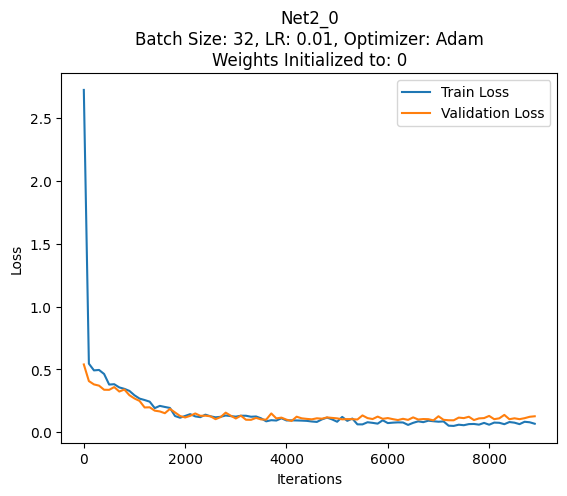

In [30]:
plot_learning_curve(CNN0_loss_avg_train, CNN0_loss_avg_valid, "Net2_0\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: 0")

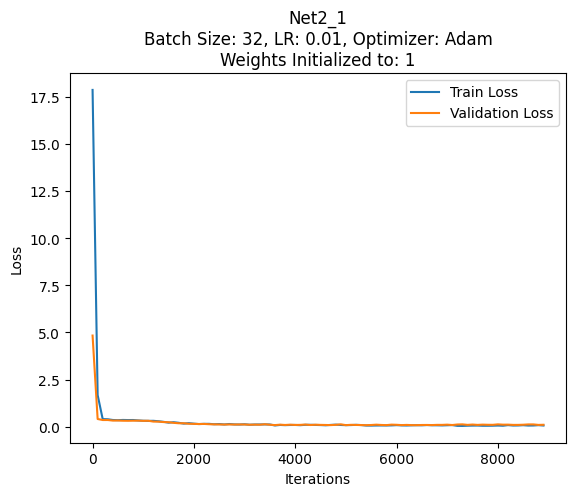

In [31]:
plot_learning_curve(CNN1_loss_avg_train, CNN1_loss_avg_valid, "Net2_1\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: 1")

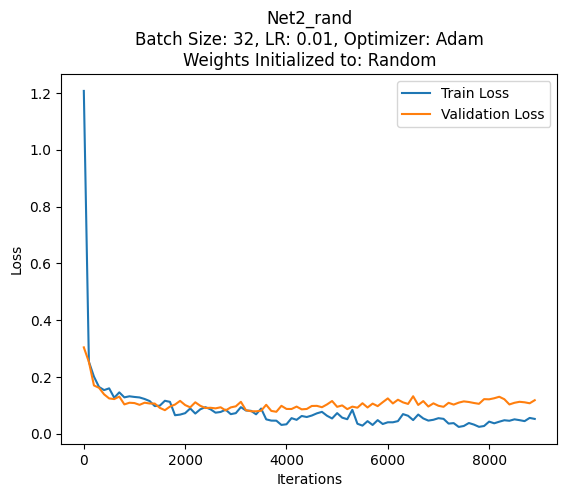

In [32]:
plot_learning_curve(CNNrand_loss_avg_train, CNNrand_loss_avg_valid, "Net2_rand\nBatch Size: 32, LR: 0.01, Optimizer: Adam\nWeights Initialized to: Random")

---

### 5.5) Activation Function

Please change the relu function in the example code to a tanh function. Use 2-Layer CNN.

#### **Q 5.5) How does changing the activation function to tanh affect the performance. Is it better or worse? Explain why.**

Changing the function to tanh decreased the performance because it causes slower convergence due to having lower value gradients for positive values which is what we have in the image input.

In [33]:
# Define 2-Layer Network
class Net2_tanh(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2_tanh, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3, stride=1)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(26*26 * 20, num_classes) # 3x3 kernel with no padding, original image is 28x28, so 26 x 26

    def forward(self, x):
        out = self.conv1(x)
        out = self.tanh(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc2(out)
        return out

In [34]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2_tanh(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNNtanh_acc_arr_train, CNNtanh_acc_arr_valid, CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/1875], Train Loss: 0.7501, Val Loss: 0.5185
Epoch [1/5], Step [200/1875], Train Loss: 0.2599, Val Loss: 0.4520
Epoch [1/5], Step [300/1875], Train Loss: 0.2422, Val Loss: 0.3890
Epoch [1/5], Step [400/1875], Train Loss: 0.7420, Val Loss: 0.3962
Epoch [1/5], Step [500/1875], Train Loss: 0.5013, Val Loss: 0.3783
Epoch [1/5], Step [600/1875], Train Loss: 0.5127, Val Loss: 0.3704
Epoch [1/5], Step [700/1875], Train Loss: 0.0755, Val Loss: 0.3481
Epoch [1/5], Step [800/1875], Train Loss: 0.6834, Val Loss: 0.3787
Epoch [1/5], Step [900/1875], Train Loss: 0.3436, Val Loss: 0.4108
Epoch [1/5], Step [1000/1875], Train Loss: 0.7199, Val Loss: 0.3881
Epoch [1/5], Step [1100/1875], Train Loss: 0.2310, Val Loss: 0.4742
Epoch [1/5], Step [1200/1875], Train Loss: 0.5795, Val Loss: 0.4331
Epoch [1/5], Step [1300/1875], Train Loss: 0.6598, Val Loss: 0.4266
Epoch [1/5], Step [1400/1875], Train Loss: 0.3186, Val Loss: 0.3993
Epoch [1/5], Step [1500/1875], Train Loss: 0.3072, Val Lo

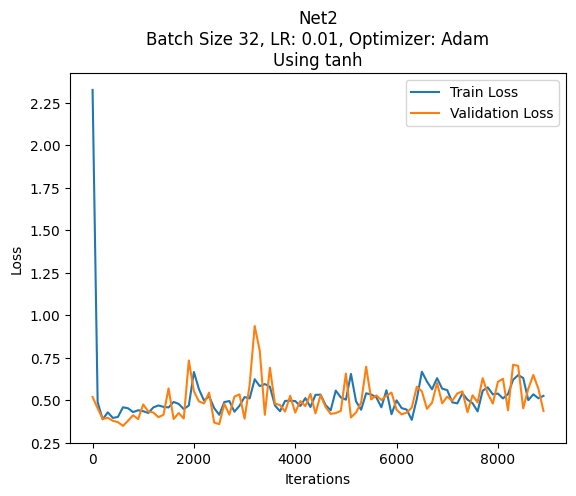

In [35]:
plot_learning_curve(CNNtanh_loss_avg_train, CNNtanh_loss_avg_valid, "Net2\nBatch Size 32, LR: 0.01, Optimizer: Adam\nUsing tanh")

---

### 5.6) Batch Size

Please use batch size of 128, 256, 512. Use 2-Layer CNN.

#### **Q 5.6) How does changing batch size affect the training process?**

Having larger batch sizes can lead to better generalization as the gradients are updated based on a larger amount of data which prevents outliers from having a large impact. It will take longer however since more memory needs to be allocated on the GPU for a larger batch to be processed. It could require more epochs to be done to converge as the gradients are updated less often so less steps are taken in the direction of the gradient which causes slower convergence.

In [36]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [37]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_1_acc_arr_train, CNN_1_acc_arr_valid, CNN_1_loss_avg_train, CNN_1_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/468], Train Loss: 0.2936, Val Loss: 0.1825
Epoch [1/5], Step [200/468], Train Loss: 0.1112, Val Loss: 0.1261
Epoch [1/5], Step [300/468], Train Loss: 0.2077, Val Loss: 0.1033
Epoch [1/5], Step [400/468], Train Loss: 0.0691, Val Loss: 0.1013
Epoch [1/5], Time Taken: 3.7524, Train Acc: 97.8833, Valid Acc: 97.3700
--------------------------------------------------------------
Epoch [2/5], Step [100/468], Train Loss: 0.1087, Val Loss: 0.0781
Epoch [2/5], Step [200/468], Train Loss: 0.0889, Val Loss: 0.0770
Epoch [2/5], Step [300/468], Train Loss: 0.1110, Val Loss: 0.0780
Epoch [2/5], Step [400/468], Train Loss: 0.0432, Val Loss: 0.0761
Epoch [2/5], Time Taken: 3.7113, Train Acc: 98.4267, Valid Acc: 97.4600
--------------------------------------------------------------
Epoch [3/5], Step [100/468], Train Loss: 0.0598, Val Loss: 0.0783
Epoch [3/5], Step [200/468], Train Loss: 0.0337, Val Loss: 0.0737
Epoch [3/5], Step [300/468], Train Loss: 0.0127, Val Loss: 0.0717
Epoc

In [38]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [39]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_2_acc_arr_train, CNN_2_acc_arr_valid, CNN_2_loss_avg_train, CNN_2_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/234], Train Loss: 0.1091, Val Loss: 0.1171
Epoch [1/5], Step [200/234], Train Loss: 0.0479, Val Loss: 0.0880
Epoch [1/5], Time Taken: 2.6285, Train Acc: 98.1333, Valid Acc: 97.6700
--------------------------------------------------------------
Epoch [2/5], Step [100/234], Train Loss: 0.0693, Val Loss: 0.0791
Epoch [2/5], Step [200/234], Train Loss: 0.0560, Val Loss: 0.0734
Epoch [2/5], Time Taken: 2.3825, Train Acc: 98.7083, Valid Acc: 97.7800
--------------------------------------------------------------
Epoch [3/5], Step [100/234], Train Loss: 0.0282, Val Loss: 0.0758
Epoch [3/5], Step [200/234], Train Loss: 0.0350, Val Loss: 0.0713
Epoch [3/5], Time Taken: 2.6405, Train Acc: 99.0650, Valid Acc: 97.6800
--------------------------------------------------------------
Epoch [4/5], Step [100/234], Train Loss: 0.0130, Val Loss: 0.0705
Epoch [4/5], Step [200/234], Train Loss: 0.0470, Val Loss: 0.0769
Epoch [4/5], Time Taken: 3.1829, Train Acc: 99.3433, Valid Acc: 97.

In [40]:
batch_size = 512

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [41]:
# Define Parameters
input_size = 784
num_classes = 10
lr = .01
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# Train Model
CNN_3_acc_arr_train, CNN_3_acc_arr_valid, CNN_3_loss_avg_train, CNN_3_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/117], Train Loss: 0.1978, Val Loss: 0.1950
Epoch [1/5], Time Taken: 2.4735, Train Acc: 95.5567, Valid Acc: 95.6800
--------------------------------------------------------------
Epoch [2/5], Step [100/117], Train Loss: 0.0963, Val Loss: 0.0982
Epoch [2/5], Time Taken: 2.3226, Train Acc: 97.6567, Valid Acc: 97.2700
--------------------------------------------------------------
Epoch [3/5], Step [100/117], Train Loss: 0.0552, Val Loss: 0.0794
Epoch [3/5], Time Taken: 2.5172, Train Acc: 98.3300, Valid Acc: 97.6900
--------------------------------------------------------------
Epoch [4/5], Step [100/117], Train Loss: 0.0752, Val Loss: 0.0676
Epoch [4/5], Time Taken: 2.3652, Train Acc: 98.7633, Valid Acc: 97.5600
--------------------------------------------------------------
Epoch [5/5], Step [100/117], Train Loss: 0.0427, Val Loss: 0.0758
Epoch [5/5], Time Taken: 2.3161, Train Acc: 98.9067, Valid Acc: 97.7100
----------------------------------------------------------

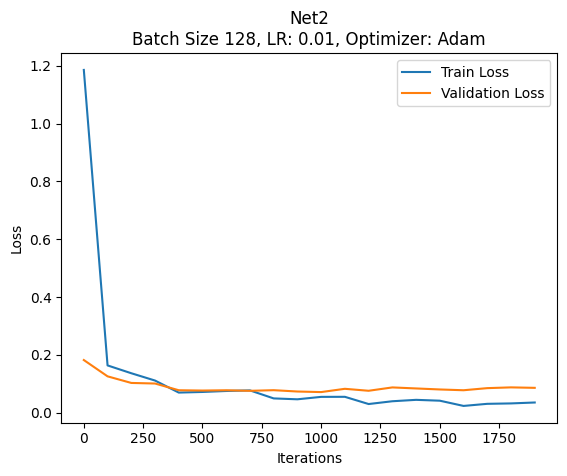

In [42]:
plot_learning_curve(CNN_1_loss_avg_train, CNN_1_loss_avg_valid, "Net2\nBatch Size 128, LR: 0.01, Optimizer: Adam")

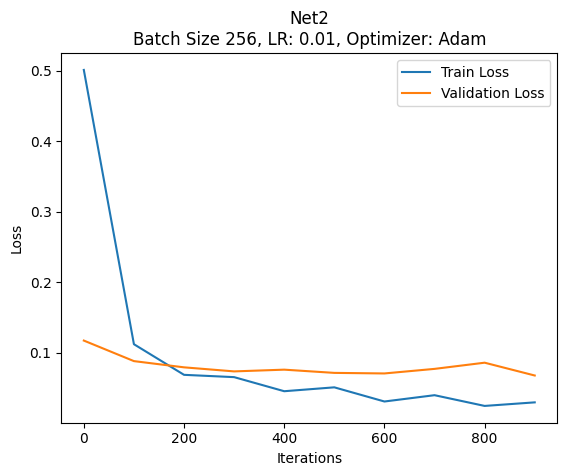

In [43]:
plot_learning_curve(CNN_2_loss_avg_train, CNN_2_loss_avg_valid, "Net2\nBatch Size 256, LR: 0.01, Optimizer: Adam")

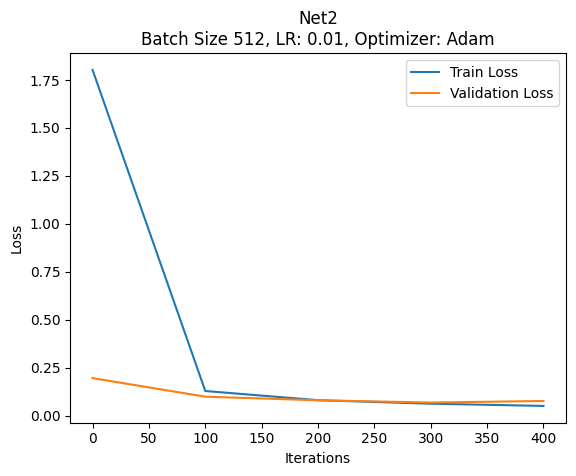

In [44]:
plot_learning_curve(CNN_3_loss_avg_train, CNN_3_loss_avg_valid, "Net2\nBatch Size 512, LR: 0.01, Optimizer: Adam")

---

### 5.7) Different Network Architectures

Please complete the `Net5` and `FCN` definitions. The archtiectures are defined below.

Train `Net`, `Net2`, `Net5`, and `FCN` using batch size of 64, the best learning rate from Section 5.1, and the best optimizer froom Section 5.5

#### **Q 5.7.1) Explain which model is better and why. Use your learning curves as well as what you know about model capacity to explain your reasoning.**

#### **Q 5.7.2) Which model converges to a minimum faster? Why? What hyperparameters would you tune in order to get a model to converge faster?**

#### **Q 5.7.3) Explain the purpose of the pooling layer**

#### **Q 5.7.4)  Is it possible for a model to have a smaller final loss, even if it has worse test accuracy.**

#### **Q 5.7.5) Explain the difference between the CNN models and FCN.**

5.7.1 The Net model is better because it a shallower network. The Net5 model overfits because it is a deeper network, which leads to a lower accuracy compared to the Net. The same logic can be applied for the Net2, which is close in accuracy to the Net. The Net has a higher accuracy than the FCN most likely because FCNs are best when used for pixel-level predictions and highly detailed spatial localization. CNNs shine in single output predictions in relation to the entire image.

5.7.2 Net5 converges to a minimum faster. This makes sense due to its higher complexity and thus can be seen overfitting the data. As a result, it converges to the minimum much quicker. To have a model converge faster, we would increase the learning rate, and lowering the batch size so that less steps are taken per epoch.

5.7.3 : The purpose of the pooling layer is to reduce the dimensions of the input volume, decreasing the amount of parameters in the neural network, which ultimately lends way to a reduction of overfitting

5.7.4: Yes, it's possible for a model to have a smaller final loss with a worse test accuracy. This may occur if the model is overfitted, and struggles to generalize. The finals loss is lower as it indicates a good fit.

5.7.5 The CNN model uses layers and is better fitted for single output prediction tasks that take into account the entire image. The FCN model identifies the objects in the individual pixels of an image, and thus is better fitted when used for pixel-level predicitions and more highly detailed spatial localization tasks.



In [45]:
# Define 5-Layer Network
class Net5(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # After max pool, dimensions are 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
        self.relu = nn.ReLU() # No Max Pool, so we'll use ReLU to activate
        self.fc1 = nn.Linear(14*14 * 64,  1024) # Original image is 28x28, after max pool, dimensions are now 14x14
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [46]:
# Define FCN
class FCN(nn.Module):
    def __init__(self, input_size, num_classes):
      super(FCN, self).__init__()
      self.fc1 = nn.Linear(input_size, 256) # Input size should be 28x28, or 784
      self.relu1 = nn.ReLU()
      self.fc2 = nn.Linear(256, 256)
      self.relu2 = nn.ReLU()
      self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
      x = torch.flatten(x, 1)
      out = self.fc1(x)
      out = self.relu1(out)
      out = self.fc2(out)
      out = self.relu2(out)
      out = self.fc3(out)
      return out

In [47]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

In [48]:

# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net_64_acc_arr_train, Net_64_acc_arr_valid, Net_64_loss_avg_train, Net_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.2529, Val Loss: 2.2474
Epoch [1/5], Step [200/937], Train Loss: 2.1980, Val Loss: 2.1732
Epoch [1/5], Step [300/937], Train Loss: 2.0945, Val Loss: 2.0951
Epoch [1/5], Step [400/937], Train Loss: 2.0006, Val Loss: 2.0089
Epoch [1/5], Step [500/937], Train Loss: 1.9208, Val Loss: 1.9141
Epoch [1/5], Step [600/937], Train Loss: 1.8418, Val Loss: 1.8122
Epoch [1/5], Step [700/937], Train Loss: 1.6347, Val Loss: 1.7044
Epoch [1/5], Step [800/937], Train Loss: 1.6318, Val Loss: 1.5946
Epoch [1/5], Step [900/937], Train Loss: 1.5733, Val Loss: 1.4872
Epoch [1/5], Time Taken: 6.1346, Train Acc: 76.6167, Valid Acc: 77.6600
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 1.4282, Val Loss: 1.3463
Epoch [2/5], Step [200/937], Train Loss: 1.3589, Val Loss: 1.2530
Epoch [2/5], Step [300/937], Train Loss: 1.2903, Val Loss: 1.1684
Epoch [2/5], Step [400/937], Train Loss: 1.1239, Val Loss: 1.0929
Epoch [

In [49]:
# Net2
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net2(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net2_64_acc_arr_train, Net2_64_acc_arr_valid, Net2_64_loss_avg_train, Net2_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 1.5902, Val Loss: 1.4877
Epoch [1/5], Step [200/937], Train Loss: 0.9293, Val Loss: 0.9114
Epoch [1/5], Step [300/937], Train Loss: 0.6338, Val Loss: 0.6672
Epoch [1/5], Step [400/937], Train Loss: 0.5943, Val Loss: 0.5496
Epoch [1/5], Step [500/937], Train Loss: 0.3077, Val Loss: 0.4841
Epoch [1/5], Step [600/937], Train Loss: 0.4177, Val Loss: 0.4454
Epoch [1/5], Step [700/937], Train Loss: 0.4435, Val Loss: 0.4199
Epoch [1/5], Step [800/937], Train Loss: 0.3815, Val Loss: 0.3978
Epoch [1/5], Step [900/937], Train Loss: 0.5173, Val Loss: 0.3847
Epoch [1/5], Time Taken: 5.5873, Train Acc: 88.8867, Valid Acc: 89.6000
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.4235, Val Loss: 0.3704
Epoch [2/5], Step [200/937], Train Loss: 0.4040, Val Loss: 0.3618
Epoch [2/5], Step [300/937], Train Loss: 0.5179, Val Loss: 0.3542
Epoch [2/5], Step [400/937], Train Loss: 0.4799, Val Loss: 0.3465
Epoch [

In [50]:
# Net5
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = Net5(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
Net5_64_acc_arr_train, Net5_64_acc_arr_valid, Net5_64_loss_avg_train, Net5_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.1535, Val Loss: 2.1600
Epoch [1/5], Step [200/937], Train Loss: 1.8672, Val Loss: 1.8305
Epoch [1/5], Step [300/937], Train Loss: 1.1387, Val Loss: 1.2024
Epoch [1/5], Step [400/937], Train Loss: 0.8005, Val Loss: 0.7467
Epoch [1/5], Step [500/937], Train Loss: 0.5916, Val Loss: 0.5710
Epoch [1/5], Step [600/937], Train Loss: 0.5238, Val Loss: 0.4867
Epoch [1/5], Step [700/937], Train Loss: 0.4482, Val Loss: 0.4509
Epoch [1/5], Step [800/937], Train Loss: 0.3439, Val Loss: 0.4165
Epoch [1/5], Step [900/937], Train Loss: 0.3253, Val Loss: 0.3928
Epoch [1/5], Time Taken: 6.8408, Train Acc: 88.1517, Valid Acc: 88.6500
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.4476, Val Loss: 0.3800
Epoch [2/5], Step [200/937], Train Loss: 0.4413, Val Loss: 0.3610
Epoch [2/5], Step [300/937], Train Loss: 0.3822, Val Loss: 0.3579
Epoch [2/5], Step [400/937], Train Loss: 0.4731, Val Loss: 0.3487
Epoch [

In [51]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 1-Layer Model
net = FCN(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
FCN_64_acc_arr_train, FCN_64_acc_arr_valid, FCN_64_loss_avg_train, FCN_64_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 2.3014, Val Loss: 2.2954
Epoch [1/5], Step [200/937], Train Loss: 2.2858, Val Loss: 2.2835
Epoch [1/5], Step [300/937], Train Loss: 2.2650, Val Loss: 2.2706
Epoch [1/5], Step [400/937], Train Loss: 2.2539, Val Loss: 2.2560
Epoch [1/5], Step [500/937], Train Loss: 2.2406, Val Loss: 2.2392
Epoch [1/5], Step [600/937], Train Loss: 2.2146, Val Loss: 2.2196
Epoch [1/5], Step [700/937], Train Loss: 2.2089, Val Loss: 2.1964
Epoch [1/5], Step [800/937], Train Loss: 2.1597, Val Loss: 2.1696
Epoch [1/5], Step [900/937], Train Loss: 2.1493, Val Loss: 2.1364
Epoch [1/5], Time Taken: 5.8343, Train Acc: 66.5333, Valid Acc: 66.7100
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 2.0843, Val Loss: 2.0793
Epoch [2/5], Step [200/937], Train Loss: 2.0697, Val Loss: 2.0288
Epoch [2/5], Step [300/937], Train Loss: 1.9809, Val Loss: 1.9687
Epoch [2/5], Step [400/937], Train Loss: 1.9287, Val Loss: 1.8981
Epoch [

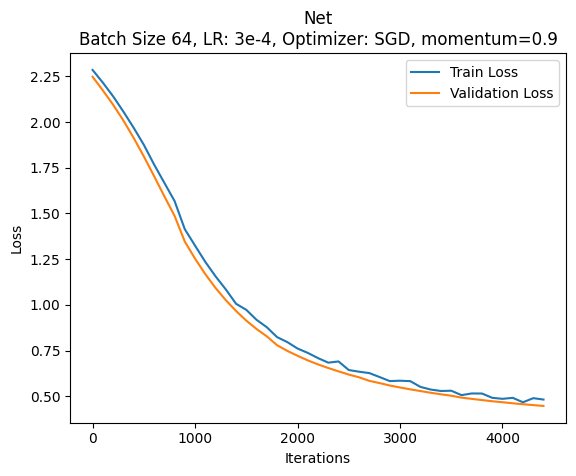

In [52]:
plot_learning_curve(Net_64_loss_avg_train, Net_64_loss_avg_valid, "Net\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

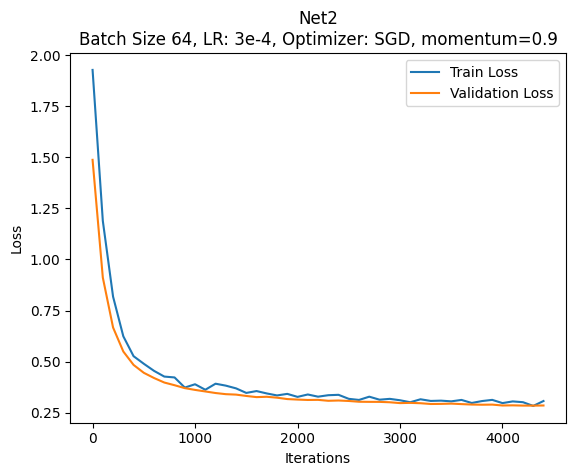

In [53]:
plot_learning_curve(Net2_64_loss_avg_train, Net2_64_loss_avg_valid, "Net2\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

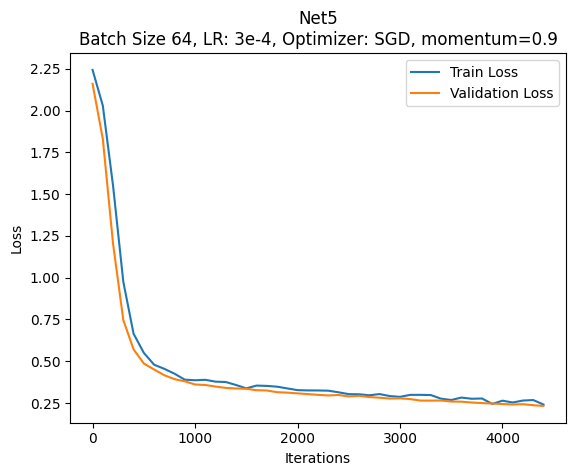

In [54]:
plot_learning_curve(Net5_64_loss_avg_train, Net5_64_loss_avg_valid, "Net5\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

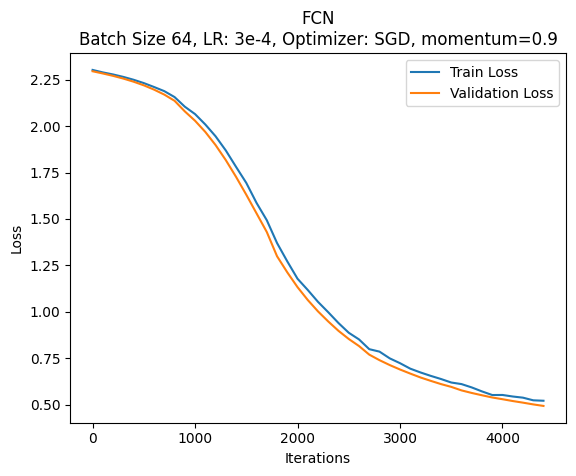

In [55]:
plot_learning_curve(FCN_64_loss_avg_train, FCN_64_loss_avg_valid, "FCN\nBatch Size 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

#### 5-Layer CNN
Similar to the 2-Layer model, make a new class ```Net5```

* ***Layer 1 (Input)***: Convolutional, input channel = 1, output channel = 32, kernel size = 5, stride = 1, padding = 2.
* ***Layer 2 (Hidden 1)***: Pooling, kernel size = 2, stride = 2.
* ***Layer 3 (Hidden 2)***: Convolutional, input channel = < you find out> , output channel = 64, kernel size = 5, stride = 1 padding = 2.
* ***Layer 4 (Hidden 3)***: Fully connected, input channel = < you find out>, output channel = 1024.
* ***Layer 5 (Output)***: Fully connected, input channel = < you find out>, < you find out >

#### FCN

Here we will define a Fully Connected Network `FCN` (Not a CNN).

- **Layer 1 (Input):** Size = < you find out >
- **Layer 2 (Hidden 1):** 256 neurons
- **Layer 3 (Hidden 2):** 256 neurons
- **Layer 4 (Output):** Size = < you find out >



---



---



### 5.8) Batch Normalization

Choose the model that performs the best (`Net`, `Net2`, `Net5`, `FCN`). Add batch normalization layers where you see fit. Repeat and train and plot learning curves.

#### **Q 5.8) Explain the purpose of the batch normalization layers,and how they affect training.**



5.8 Batch Normalization layers are used to normalize the output of a layer in the neural network. These normalized inputs prevent the activations from getting to large or small, issues that can cause gradient vanishing in some cases. As a result of the normalized inputs, batch normilzation stabilizes and speeds up the training process.

In [56]:
# Define 5-Layer Network
class Net5_Batch_Layers(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net5_Batch_Layers, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2)
        self.batch1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # After max pool, dimensions are 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = 2)
        self.batch2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU() # No Max Pool, so we'll use ReLU to activate
        self.fc1 = nn.Linear(14*14 * 64,  1024) # Original image is 28x28, after max pool, dimensions are now 14x14
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        out = self.conv1(x)
        out = self.batch1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.batch2(out)
        out = self.relu(out)
        out = torch.flatten(out, 1) # Flatten the matrices, convert multidimensional array to single dimensional vector
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [57]:
# Define Parameters
batch_size = 64
input_size = 784
num_classes = 10
lr = 3e-4
num_epochs = 5

# Instantiate 2-Layer Model with batch normalization layers
net = Net5_Batch_Layers(input_size, num_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)

# Train Model
batch_norm_acc_arr_train, batch_norm_acc_arr_valid, batch_norm_loss_avg_train, batch_norm_loss_avg_valid = train(net, loss_function, optimizer, train_loader, batch_size, num_epochs, device)

Epoch [1/5], Step [100/937], Train Loss: 0.6392, Val Loss: 0.5313
Epoch [1/5], Step [200/937], Train Loss: 0.4210, Val Loss: 0.3765
Epoch [1/5], Step [300/937], Train Loss: 0.4195, Val Loss: 0.3142
Epoch [1/5], Step [400/937], Train Loss: 0.4254, Val Loss: 0.2737
Epoch [1/5], Step [500/937], Train Loss: 0.2469, Val Loss: 0.2465
Epoch [1/5], Step [600/937], Train Loss: 0.2604, Val Loss: 0.2279
Epoch [1/5], Step [700/937], Train Loss: 0.2063, Val Loss: 0.2087
Epoch [1/5], Step [800/937], Train Loss: 0.2676, Val Loss: 0.1960
Epoch [1/5], Step [900/937], Train Loss: 0.2256, Val Loss: 0.1803
Epoch [1/5], Time Taken: 7.0870, Train Acc: 94.9383, Valid Acc: 95.2600
--------------------------------------------------------------
Epoch [2/5], Step [100/937], Train Loss: 0.1277, Val Loss: 0.1679
Epoch [2/5], Step [200/937], Train Loss: 0.0878, Val Loss: 0.1576
Epoch [2/5], Step [300/937], Train Loss: 0.1848, Val Loss: 0.1494
Epoch [2/5], Step [400/937], Train Loss: 0.1810, Val Loss: 0.1410
Epoch [

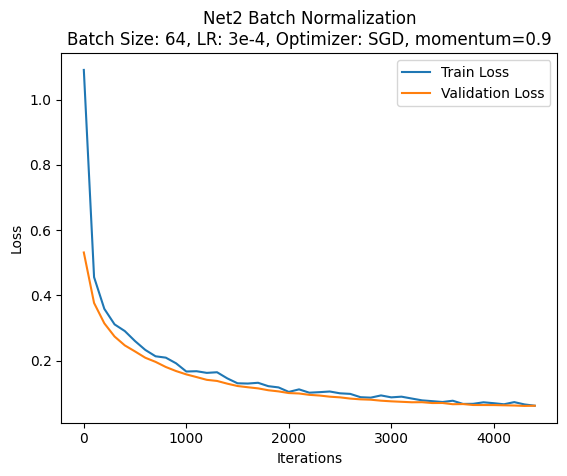

In [58]:
plot_learning_curve(batch_norm_loss_avg_train, batch_norm_loss_avg_valid, "Net2 Batch Normalization\nBatch Size: 64, LR: 3e-4, Optimizer: SGD, momentum=0.9")

---